In [1]:
%config Completer.use_jedi = False
%reload_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
!pip show tensorflow

In [3]:
import os
import datetime
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# Extracting Data

In [4]:
#Function to load battery discharge .mat file
def load_data_discharge(battery):
  mat = loadmat('battery_data/' + battery + '.mat')
  print('Total data in dataset ' + battery + ': ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  #print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]

In [5]:
#Function to load battery charge .mat file
def load_data_charge(battery):
  mat = loadmat('battery_data/' + battery + '.mat')
  print('Total data in dataset ' + battery + ': ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'charge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_charge = data[0][0]['Current_charge'][0][j]
        voltage_charge = data[0][0]['Voltage_charge'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, 
                        voltage_measured, current_measured,
                        temperature_measured, current_charge,
                        voltage_charge, time])
      counter = counter + 1
  #print(dataset[0])
  return pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_charge', 'voltage_charge', 'time'])

In [6]:
#Load all batteries' discharge and its measured capacity
B0005_discharge, B0005_capacity = load_data_discharge('B0005')
B0006_discharge, B0006_capacity = load_data_discharge('B0006')
B0007_discharge, B0007_capacity = load_data_discharge('B0007')
B0018_discharge, B0018_capacity = load_data_discharge('B0018')

Total data in dataset B0005:  616
Total data in dataset B0006:  616
Total data in dataset B0007:  616
Total data in dataset B0018:  319


In [7]:
#Load all batteries' charge
B0005_charge = load_data_charge('B0005')
B0006_charge = load_data_charge('B0006')
B0007_charge = load_data_charge('B0007')
B0018_charge = load_data_charge('B0018')

Total data in dataset B0005:  616
Total data in dataset B0006:  616
Total data in dataset B0007:  616
Total data in dataset B0018:  319


In [8]:
# Function to add 'capacity' column to charge DataFrame based on matching cycles
def add_capacity_to_charge(charge_df, capacity_df):
    # Initialize the 'capacity' column with NaNs
    charge_df['capacity'] = None
    
    # Iterate through the charge DataFrame
    for index, row in charge_df.iterrows():
        # Find the corresponding capacity value for the matching cycle
        capacity_row = capacity_df[capacity_df['cycle'] == row['cycle']]
        if not capacity_row.empty:
            charge_df.at[index, 'capacity'] = capacity_row['capacity'].values[0]
    
    return charge_df

# Add 'capacity' column to each charge DataFrame
B0005_charge = add_capacity_to_charge(B0005_charge, B0005_capacity)
B0006_charge = add_capacity_to_charge(B0006_charge, B0006_capacity)
B0007_charge = add_capacity_to_charge(B0007_charge, B0007_capacity)
B0018_charge = add_capacity_to_charge(B0018_charge, B0018_capacity)
print(B0005_charge)

# run time is ~20 mins

        cycle  ambient_temperature            datetime  voltage_measured  \
0           1                   24 2008-04-02 13:08:17          3.873017   
1           1                   24 2008-04-02 13:08:17          3.479394   
2           1                   24 2008-04-02 13:08:17          4.000588   
3           1                   24 2008-04-02 13:08:17          4.012395   
4           1                   24 2008-04-02 13:08:17          4.019708   
...       ...                  ...                 ...               ...   
541168    170                   24 2008-05-28 11:09:42          0.236356   
541169    170                   24 2008-05-28 11:09:42          0.003365   
541170    170                   24 2008-05-28 11:09:42          4.985137   
541171    170                   24 2008-05-28 11:09:42          4.984720   
541172    170                   24 2008-05-28 11:09:42          4.213440   

        current_measured  temperature_measured  current_charge  \
0              -0.001

Need to remove cycles that don't have capacity readings.

Cycle 169 for the first 3 batteries.

Cycles 133 and 134 for the last battery.

In [9]:
# Remove rows where 'capacity' is empty or zero
B0005_charge = B0005_charge[B0005_charge['capacity'].notna() & (B0005_charge['capacity'] != '')]
B0006_charge = B0006_charge[B0006_charge['capacity'].notna() & (B0006_charge['capacity'] != '')]
B0007_charge = B0007_charge[B0007_charge['capacity'].notna() & (B0007_charge['capacity'] != '')]
B0018_charge = B0018_charge[B0018_charge['capacity'].notna() & (B0018_charge['capacity'] != '')]

In [10]:
# Remove rows where 'capacity' is empty or zero
B0005_discharge = B0005_discharge[B0005_discharge['capacity'].notna() & (B0005_discharge['capacity'] != '')]
B0006_discharge = B0006_discharge[B0006_discharge['capacity'].notna() & (B0006_discharge['capacity'] != '')]
B0007_discharge = B0007_discharge[B0007_discharge['capacity'].notna() & (B0007_discharge['capacity'] != '')]
B0018_discharge = B0018_discharge[B0018_discharge['capacity'].notna() & (B0018_discharge['capacity'] != '')]

Remove Outliers by clipping the voltage. Only for charging data.

In [11]:
# Clip 'voltage_measured' at 4.2
B0005_charge['voltage_measured'] = B0005_charge['voltage_measured'].clip(upper=4.2)
B0006_charge['voltage_measured'] = B0006_charge['voltage_measured'].clip(upper=4.2)
B0007_charge['voltage_measured'] = B0007_charge['voltage_measured'].clip(upper=4.2)
B0018_charge['voltage_measured'] = B0018_charge['voltage_measured'].clip(upper=4.2)

Save data to csv file to minimize run time. 

In [12]:
# Create the directory if it does not exist
output_dir = 'Raw battery data'
os.makedirs(output_dir, exist_ok=True)

# Dictionary of DataFrames
dfs = {
    'B0005_charge': B0005_charge,
    'B0006_charge': B0006_charge,
    'B0007_charge': B0007_charge,
    'B0018_charge': B0018_charge,
    'B0005_discharge': B0005_discharge,
    'B0006_discharge': B0006_discharge,
    'B0007_discharge': B0007_discharge,
    'B0018_discharge': B0018_discharge
}

# Save each DataFrame to a separate CSV file in the specified directory
for name, df in dfs.items():
    df.to_csv(os.path.join(output_dir, f'{name}.csv'), index=False)

print("DataFrames saved to CSV files in 'raw battery data' directory")

DataFrames saved to CSV files in 'raw battery data' directory


Now load them back. Skip the earlier steps and start from here. 

In [46]:
# Define the directory where the CSV files are stored
input_dir = '1. Raw battery data'

# Load each CSV file into a separate DataFrame
B0005_charge = pd.read_csv(os.path.join(input_dir, 'B0005_charge.csv'))
B0006_charge = pd.read_csv(os.path.join(input_dir, 'B0006_charge.csv'))
B0007_charge = pd.read_csv(os.path.join(input_dir, 'B0007_charge.csv'))
B0018_charge = pd.read_csv(os.path.join(input_dir, 'B0018_charge.csv'))

B0005_discharge = pd.read_csv(os.path.join(input_dir, 'B0005_discharge.csv'))
B0006_discharge = pd.read_csv(os.path.join(input_dir, 'B0006_discharge.csv'))
B0007_discharge = pd.read_csv(os.path.join(input_dir, 'B0007_discharge.csv'))
B0018_discharge = pd.read_csv(os.path.join(input_dir, 'B0018_discharge.csv'))

# Print the first few rows of each DataFrame to verify
print("B0005_charge DataFrame:")
print(B0005_charge.head())

B0005_charge DataFrame:
   cycle  ambient_temperature             datetime  voltage_measured  \
0      1                   24  2008-04-02 13:08:17          3.873017   
1      1                   24  2008-04-02 13:08:17          3.479394   
2      1                   24  2008-04-02 13:08:17          4.000588   
3      1                   24  2008-04-02 13:08:17          4.012395   
4      1                   24  2008-04-02 13:08:17          4.019708   

   current_measured  temperature_measured  current_charge  voltage_charge  \
0         -0.001201             24.655358           0.000           0.003   
1         -4.030268             24.666480          -4.036           1.570   
2          1.512731             24.675394           1.500           4.726   
3          1.509063             24.693865           1.500           4.742   
4          1.511318             24.705069           1.500           4.753   

     time  capacity  
0   0.000  1.856487  
1   2.532  1.856487  
2   5.500  1.8

Reshape V I T profiles for each cycle seperately, to each contain 10 columns of data. Average the data to include one row for each cycle with 10 datapoints for each VIT profile and reduce noise. Resulting in 1x30 vector for each cycle.

In [47]:
data_length = 10
def process_cycle_data(cycle_data):
    # Ensure the length is divisible by 10
    remainder = len(cycle_data) % data_length
    if remainder != 0:
        cycle_data = cycle_data[:-remainder]
    
    # Reshape the data to have 10 samples per row
    reshaped_data = cycle_data.reshape(-1, data_length)
    
    # Average each column
    averaged_data = reshaped_data.mean(axis=0)
    
    return averaged_data

def process_battery_data(df):
    processed_data = []

    # Get the unique cycles
    unique_cycles = df['cycle'].unique()

    for cycle in unique_cycles:
        # Filter data for the current cycle
        cycle_data = df[df['cycle'] == cycle]

        # Process 'voltage_measured'
        voltage_data = process_cycle_data(cycle_data['voltage_measured'].values)
        
        # Process 'current_measured'
        current_data = process_cycle_data(cycle_data['current_measured'].values)
        
        # Process 'temperature_measured'
        temperature_data = process_cycle_data(cycle_data['temperature_measured'].values)
        
        # Concatenate the averaged data into a single row
        combined_data = np.concatenate([voltage_data, current_data, temperature_data])
        processed_data.append(combined_data)
    
    # Create a DataFrame from the processed data
    processed_df = pd.DataFrame(processed_data, columns=[f'v{i+1}' for i in range(data_length)] + 
                                                  [f'c{i+1}' for i in range(data_length)] + 
                                                  [f't{i+1}' for i in range(data_length)])
    
    return processed_df

def process_battery_data_combined(df, df2):
    processed_data = []

    # Get the unique cycles
    unique_cycles_ch = df['cycle'].unique()
    # unique_cycles_disch = df2['cycle'].unique()
    
    for cycle in unique_cycles_ch:
        # Filter data for the current cycle
        cycle_data_ch = df[df['cycle'] == cycle]
        cycle_data_disch = df2[df2['cycle'] == cycle]
        # Process 'voltage_measured'
        voltage_data_ch = process_cycle_data(cycle_data_ch['voltage_measured'].values)
        voltage_data_disch = process_cycle_data(cycle_data_disch['voltage_measured'].values)
        # Process 'current_measured'
        current_data_ch = process_cycle_data(cycle_data_ch['current_measured'].values)
        current_data_disch = process_cycle_data(cycle_data_disch['current_measured'].values)
        # Process 'temperature_measured'
        temperature_data_ch = process_cycle_data(cycle_data_ch['temperature_measured'].values)
        temperature_data_disch = process_cycle_data(cycle_data_disch['temperature_measured'].values)
        # Concatenate the averaged data into a single row
        combined_data = np.concatenate([voltage_data_ch, current_data_ch, temperature_data_ch, voltage_data_disch, current_data_disch,temperature_data_disch])
        processed_data.append(combined_data)
    
    # Create a DataFrame from the processed data
    processed_df = pd.DataFrame(processed_data, columns=[f'v_ch{i+1}' for i in range(data_length)] + 
                                                  [f'c_ch{i+1}' for i in range(data_length)] + 
                                                  [f't_ch{i+1}' for i in range(data_length)]+
                                                  [f'v_dis{i+1}' for i in range(data_length)] + 
                                                  [f'c_dis{i+1}' for i in range(data_length)] + 
                                                  [f't_dis{i+1}' for i in range(data_length)])
    
    return processed_df
# Example usage
# Assuming B0005_charge is already loaded as a pandas DataFrame
# B0005_charge = pd.read_csv('B0005_charge.csv')

processed_VIT_B0005_df = process_battery_data(B0005_charge)
processed_VIT_B0006_df = process_battery_data(B0006_charge)
processed_VIT_B0007_df = process_battery_data(B0007_charge)
processed_VIT_B0018_df = process_battery_data(B0018_charge)

processed_disVIT_B0005_df = process_battery_data(B0005_discharge)
processed_disVIT_B0006_df = process_battery_data(B0006_discharge)
processed_disVIT_B0007_df = process_battery_data(B0007_discharge)
processed_disVIT_B0018_df = process_battery_data(B0018_discharge)

combined_VIT_B0005_df = process_battery_data_combined(B0005_charge, B0005_discharge)
combined_VIT_B0006_df = process_battery_data_combined(B0006_charge, B0006_discharge)
combined_VIT_B0007_df = process_battery_data_combined(B0007_charge, B0007_discharge)
combined_VIT_B0018_df = process_battery_data_combined(B0018_charge, B0018_discharge)

processed_VIT_B0005 = process_battery_data(B0005_charge).to_numpy()
processed_VIT_B0006 = process_battery_data(B0006_charge).to_numpy()
processed_VIT_B0007 = process_battery_data(B0007_charge).to_numpy()
processed_VIT_B0018 = process_battery_data(B0018_charge).to_numpy()

processed_disVIT_B0005 = process_battery_data(B0005_discharge).to_numpy()
processed_disVIT_B0006 = process_battery_data(B0006_discharge).to_numpy()
processed_disVIT_B0007 = process_battery_data(B0007_discharge).to_numpy()
processed_disVIT_B0018 = process_battery_data(B0018_discharge).to_numpy()

combined_VIT_B0005 = process_battery_data_combined(B0005_charge, B0005_discharge).to_numpy()
combined_VIT_B0006 = process_battery_data_combined(B0006_charge, B0006_discharge).to_numpy()
combined_VIT_B0007 = process_battery_data_combined(B0007_charge, B0007_discharge).to_numpy()
combined_VIT_B0018 = process_battery_data_combined(B0018_charge, B0018_discharge).to_numpy()

# Display the first few rows of the processed data for each DataFrame
print("Combined B0005:")
print(combined_VIT_B0005_df.head())
print(combined_VIT_B0005_df.shape)
# print(processed_VIT_B0006_df.shape)
# print(processed_VIT_B0007_df.shape)
# print(processed_VIT_B0018_df.shape)

print(processed_disVIT_B0005_df.head())
print(processed_disVIT_B0005_df.shape)
print(processed_disVIT_B0006_df.shape)
print(processed_disVIT_B0007_df.shape)
print(processed_disVIT_B0018_df.shape)

# Display the first few rows of the processed data for each numpy matrix
print("Processed B0005_charge:")
print(processed_VIT_B0005[:5])
print(processed_VIT_B0005.shape)
print(processed_VIT_B0006.shape)
print(processed_VIT_B0007.shape)
print(processed_VIT_B0018.shape)

# print("\nProcessed B0006_charge:")
# print(processed_VIT_B0006.head())

# print("\nProcessed B0007_charge:")
# print(processed_B0007_charge.head())

# print("\nProcessed B0018_charge:")
# print(processed_VIT_B0018.head())

Combined B0005:
      v_ch1     v_ch2     v_ch3     v_ch4     v_ch5     v_ch6     v_ch7  \
0  4.180972  4.176154  4.182235  4.182992  4.183413  4.183735  4.184046   
1  4.050996  4.048693  4.054148  4.055161  4.056075  4.056939  4.057773   
2  4.049384  4.047177  4.052565  4.053532  4.054453  4.055318  4.056125   
3  4.051298  4.048776  4.054085  4.055003  4.055852  4.056661  4.057440   
4  4.050529  4.047142  4.052723  4.053731  4.054637  4.055464  4.056258   

      v_ch8     v_ch9    v_ch10  ...     t_dis1     t_dis2     t_dis3  \
0  4.184312  4.184588  4.184832  ...  32.214697  32.269925  32.326164   
1  4.058579  4.059385  4.060150  ...  32.387036  32.441618  32.497677   
2  4.056906  4.057679  4.058464  ...  32.328336  32.379478  32.432320   
3  4.058187  4.058921  4.058863  ...  32.207151  32.258887  32.312569   
4  4.057067  4.057819  4.058567  ...  32.070858  32.123212  32.176803   

      t_dis4     t_dis5     t_dis6     t_dis7     t_dis8     t_dis9    t_dis10  
0  32.385151 

Omit repeated cycles and capacity values.

In [48]:
def remove_duplicate_cycles(df):
    # Drop duplicates based on 'cycle' column and keep the first occurrence
    unique_cycles_df = df.drop_duplicates(subset='cycle', keep='first')
    
    # Create a new DataFrame with unique 'cycle' and 'capacity' columns
    processed_df = unique_cycles_df[['cycle', 'capacity']].reset_index(drop=True)
    
    return processed_df

# Example usage
# Assuming B0005_charge, B0006_charge, B0007_charge, B0018_charge are already loaded as pandas DataFrames
# B0005_charge = pd.read_csv('B0005_charge.csv')
# B0006_charge = pd.read_csv('B0006_charge.csv')
# B0007_charge = pd.read_csv('B0007_charge.csv')
# B0018_charge = pd.read_csv('B0018_charge.csv')

# CC: Capacity and Cycle
processed_B0005_CC = remove_duplicate_cycles(B0005_charge)
processed_B0006_CC = remove_duplicate_cycles(B0006_charge)
processed_B0007_CC = remove_duplicate_cycles(B0007_charge)
processed_B0018_CC = remove_duplicate_cycles(B0018_charge)

# Extract capacity data
capacities_B0005 = processed_B0005_CC['capacity'].values.reshape(-1, 1) # reshape from numpy row to column
capacities_B0006 = processed_B0006_CC['capacity'].values.reshape(-1, 1)
capacities_B0007 = processed_B0007_CC['capacity'].values.reshape(-1, 1)
capacities_B0018 = processed_B0018_CC['capacity'].values.reshape(-1, 1)

# Display the first few rows of the processed data for each DataFrame
print("Processed B0005_charge capacity:")
print(capacities_B0005[:5])
print(capacities_B0005.shape)
# print("\nProcessed B0006_charge capacity:")
# print(capacities_B0006[:5])

# print("\nProcessed B0007_charge capacity:")
# print(capacities_B0007[:5])

# print("\nProcessed B0018_charge capacity:")
# print(capacities_B0018[:5])


Processed B0005_charge capacity:
[[1.85648742]
 [1.84632725]
 [1.83534919]
 [1.83526253]
 [1.83464551]]
(168, 1)


Moving average: produced lower snr

In [49]:
# def moving_average_with_initial(data, init_cap, window_size=5):
#     # Perform the moving average
#     moving_avg = np.convolve(data.flatten(), np.ones(window_size)/window_size, mode='valid').reshape(-1, 1)
    
#     # Add the initial capacity points to the beginning
#     initial_data = np.full((window_size-1, 1), init_cap)
#     return np.vstack((initial_data, moving_avg))

# # Initial capacities
# Init_Cap_B0005 = 1.8565
# Init_Cap_B0006 = 2.0353
# Init_Cap_B0007 = 1.8911

# # Apply moving average and add initial capacities
# capacities_B0005 = moving_average_with_initial(capacities_B0005, Init_Cap_B0005, window_size=5)
# capacities_B0006 = moving_average_with_initial(capacities_B0006, Init_Cap_B0006, window_size=5)
# capacities_B0007 = moving_average_with_initial(capacities_B0007, Init_Cap_B0007, window_size=5)

# capacities_B0005, capacities_B0006, capacities_B0007


# Scaling Data

Practical Considerations:

Some models like neural networks might perform better with MinMaxScaler because they expect input features to be within a specific range.
Models that assume a normal distribution of input features (like many linear models) may perform better with StandardScaler.
Dataset Characteristics:

If your dataset contains many outliers, consider using StandardScaler or handling outliers separately before scaling.

MinMaxScaler

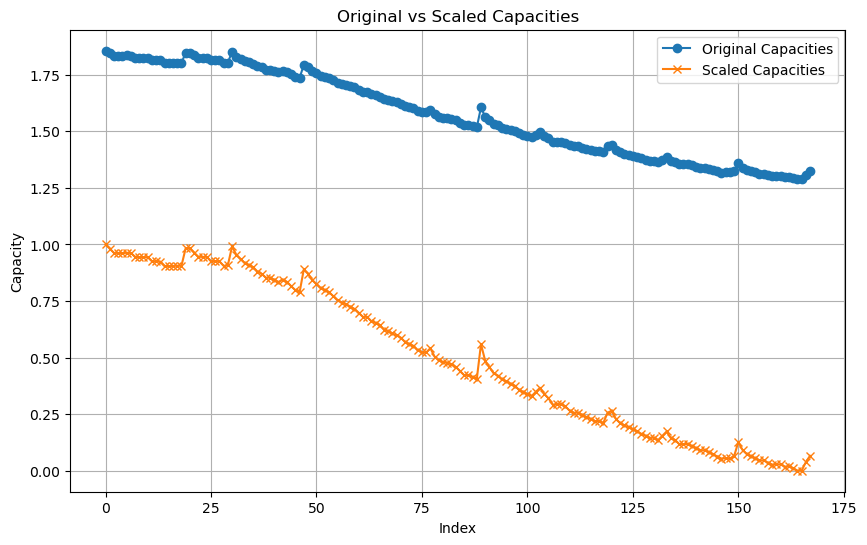

In [50]:
def minmax_norm(charInput, InitC, cap):
    # Initialize the scaler
    scaler_x = MinMaxScaler()
    
    # Normalize xData
    xData = scaler_x.fit_transform(charInput)
    
    # Calculate the difference in lengths
    comp = len(charInput) - len(cap)  # will be zero 
    # Ensure cap is a 1-dimensional array
    cap = cap.flatten()
        
    # Create yData array
    yData = np.concatenate([InitC * np.ones(comp), cap])  # InitC*comp compensates for missing data but it will be zero.
    
    # Normalize yData
    scaler_y = MinMaxScaler()
    yData = scaler_y.fit_transform(yData.reshape(-1, 1))
    
    return xData, yData, scaler_x, scaler_y

# To later reverse this normalization
def inverse_minmax_norm(xData, yData, scaler_x, scaler_y):
    # Reverse normalization for xData
    original_xData = scaler_x.inverse_transform(xData)
    
    # Reverse normalization for yData
    original_yData = scaler_y.inverse_transform(yData)
    
    return original_xData, original_yData

# Constants
Init_Cap_B0005 = 1.8565
Init_Cap_B0006 = 2.0353
Init_Cap_B0007 = 1.8911
Init_Cap_B0018 = 1.8550

# Apply normalization
xData_B0005, yData_B0005, scaler_x_B0005, scaler_y_B0005 = minmax_norm(processed_VIT_B0005, Init_Cap_B0005, capacities_B0005)
xData_B0006, yData_B0006, scaler_x_B0006, scaler_y_B0006 = minmax_norm(processed_VIT_B0006, Init_Cap_B0006, capacities_B0006)
xData_B0007, yData_B0007, scaler_x_B0007, scaler_y_B0007 = minmax_norm(processed_VIT_B0007, Init_Cap_B0007, capacities_B0007)
xData_B0018, yData_B0018, scaler_x_B0018, scaler_y_B0018 = minmax_norm(processed_VIT_B0018, Init_Cap_B0018, capacities_B0018)

xData_dis_B0005, yData_dis_B0005, scaler_x_dis_B0005, scaler_y_dis_B0005 = minmax_norm(processed_disVIT_B0005, Init_Cap_B0005, capacities_B0005)
xData_dis_B0006, yData_dis_B0006, scaler_x_dis_B0006, scaler_y_dis_B0006 = minmax_norm(processed_disVIT_B0006, Init_Cap_B0006, capacities_B0006)
xData_dis_B0007, yData_dis_B0007, scaler_x_dis_B0007, scaler_y_dis_B0007 = minmax_norm(processed_disVIT_B0007, Init_Cap_B0007, capacities_B0007)
xData_dis_B0018, yData_dis_B0018, scaler_x_dis_B0018, scaler_y_dis_B0018 = minmax_norm(processed_disVIT_B0018, Init_Cap_B0018, capacities_B0018)

xData_comb_B0005, yData_comb_B0005, scaler_x_comb_B0005, scaler_y_comb_B0005 = minmax_norm(combined_VIT_B0005, Init_Cap_B0005, capacities_B0005)
xData_comb_B0006, yData_comb_B0006, scaler_x_comb_B0006, scaler_y_comb_B0006 = minmax_norm(combined_VIT_B0006, Init_Cap_B0006, capacities_B0006)
xData_comb_B0007, yData_comb_B0007, scaler_x_comb_B0007, scaler_y_comb_B0007 = minmax_norm(combined_VIT_B0007, Init_Cap_B0007, capacities_B0007)
xData_comb_B0018, yData_comb_B0018, scaler_x_comb_B0018, scaler_y_comb_B0018 = minmax_norm(combined_VIT_B0018, Init_Cap_B0018, capacities_B0018)

# # Display the results
# print("xData_B0005:\n", xData_B0005)
# print("yData_B0005:\n", yData_B0005)
# print(yData_B0005.shape)
# Plotting the original capacities vs the scaled capacities
plt.figure(figsize=(10, 6))
plt.plot(capacities_B0005, label='Original Capacities', marker='o')
plt.plot(yData_B0005, label='Scaled Capacities', marker='x')
plt.title('Original vs Scaled Capacities')
plt.xlabel('Index')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()

Manual Scaling

In [51]:
# #scaler = MinMaxScaler()
# def minmax_norm(charInput, InitC, cap):
#     # Calculate range for normalization
#     min_charInput = np.min(charInput, axis=0) # returns minimum for each column
#     r = np.max(charInput, axis=0) - min_charInput
    
#     # Normalize xData
#     xData = (charInput - min_charInput) / r

#     # Calculate the difference in lengths
#     comp = len(charInput) - len(cap)        # will be zero 
#     # Ensure cap is a 1-dimensional array
#     cap = cap.flatten()
        
#     # Create yData array
#     yData = np.concatenate([InitC * np.ones(comp), cap])    # InitC*comp compensates for missing data but it will be zero.
    
#     # Normalize yData
#     ym = np.min(yData)
#     yr = np.max(yData) - ym
#     yData = (yData - ym) / yr
    
#     return xData, yData.reshape(-1,1), min_charInput, r, ym, yr

# # To later reverse this normalization
# def inverse_minmax_norm(xData, yData, min_charInput, r, ym, yr):
#     # Reverse normalization for xData
#     original_xData = xData * r + min_charInput
    
#     # Reverse normalization for yData
#     original_yData = yData * yr + ym
    
#     return original_xData, original_yData

# # Reverse the normalization process
# # original_xData, original_yData = inverse_minmax_norm(xData, yData, min_charInput, r, ym, yr)

# Init_Cap_B0005 = 1.8565
# Init_Cap_B0006 = 2.0353
# Init_Cap_B0007 = 1.8911
# Init_Cap_B0018 = 1.8550

# xData_B0005, yData_B0005, min_VIT_B0005, r_B0005, ym_B0005, yr_B0005 = minmax_norm(processed_VIT_B0005, Init_Cap_B0005, capacities_B0005)
# xData_B0006, yData_B0006, min_VIT_B0006, r_B0006, ym_B0006, yr_B0006 = minmax_norm(processed_VIT_B0006, Init_Cap_B0006, capacities_B0006)
# xData_B0007, yData_B0007, min_VIT_B0007, r_B0007, ym_B0007, yr_B0007 = minmax_norm(processed_VIT_B0007, Init_Cap_B0007, capacities_B0007)
# xData_B0018, yData_B0018, min_VIT_B0018, r_B0018, ym_B0018, yr_B0018 = minmax_norm(processed_VIT_B0018, Init_Cap_B0018, capacities_B0018)

# xData_dis_B0005, yData_dis_B0005, min_disVIT_B0005, r_dis_B0005, ym_B0005, yr_B0005 = minmax_norm(processed_disVIT_B0005, Init_Cap_B0005, capacities_B0005)
# xData_dis_B0006, yData_dis_B0006, min_disVIT_B0006, r_dis_B0006, ym_B0006, yr_B0006 = minmax_norm(processed_disVIT_B0006, Init_Cap_B0006, capacities_B0006)
# xData_dis_B0007, yData_dis_B0007, min_disVIT_B0007, r_dis_B0007, ym_B0007, yr_B0007 = minmax_norm(processed_disVIT_B0007, Init_Cap_B0007, capacities_B0007)
# xData_dis_B0018, yData_dis_B0018, min_disVIT_B0018, r_dis_B0018, ym_B0018, yr_B0018 = minmax_norm(processed_disVIT_B0018, Init_Cap_B0018, capacities_B0018)

# xData_comb_B0005, yData_comb_B0005, min_allVIT_B0005, r_comb_B0005, ym_B0005, yr_B0005 = minmax_norm(combined_VIT_B0005, Init_Cap_B0005, capacities_B0005)
# xData_comb_B0006, yData_comb_B0006, min_allVIT_B0006, r_comb_B0006, ym_B0006, yr_B0006 = minmax_norm(combined_VIT_B0006, Init_Cap_B0006, capacities_B0006)
# xData_comb_B0007, yData_comb_B0007, min_allVIT_B0007, r_comb_B0007, ym_B0007, yr_B0007 = minmax_norm(combined_VIT_B0007, Init_Cap_B0007, capacities_B0007)
# xData_comb_B0018, yData_comb_B0018, min_allVIT_B0018, r_comb_B0018, ym_B0018, yr_B0018 = minmax_norm(combined_VIT_B0018, Init_Cap_B0018, capacities_B0018)


# # Display the results
# print("xData_B0005:\n", xData_B0005)
# print("yData_B0005:\n", yData_B0005)
# print(yData_B0005.shape)
# print("min_VIT_B0005:", min_VIT_B0005)
# print("r_B0005:", r_B0005)
# print("ym_B0005:", ym_B0005)
# print("yr_B0005:", yr_B0005)

Standard Scaler

In [52]:
def standard_scaler(charInput, cap):
    """
    Standardizes the given data using StandardScaler from scikit-learn.
    
    Parameters:
    charInput (np.ndarray): The feature data to be standardized.
    cap (np.ndarray): The capacity data to be standardized.
    
    Returns:
    np.ndarray: Standardized feature data.
    np.ndarray: Standardized capacity data.
    StandardScaler: Scaler object for feature data.
    StandardScaler: Scaler object for capacity data.
    """
    # Initialize the scalers
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()

    # Standardize charInput
    standardized_charInput = scaler_x.fit_transform(charInput)
    
    # Ensure cap is 1-dimensional
    cap = cap.flatten()
    
    # Standardize yData
    standardized_yData = scaler_y.fit_transform(cap.reshape(-1, 1))
    
    return standardized_charInput, standardized_yData, scaler_x, scaler_y

def inverse_standard_scaler(standardized_charInput, standardized_yData, scaler_x, scaler_y):
    """
    Converts standardized data back to the original scale using the provided StandardScaler objects.
    
    Parameters:
    standardized_charInput (np.ndarray): The standardized feature data.
    standardized_yData (np.ndarray): The standardized capacity data.
    scaler_x (StandardScaler): Scaler object used to standardize feature data.
    scaler_y (StandardScaler): Scaler object used to standardize capacity data.
    
    Returns:
    np.ndarray: Original feature data.
    np.ndarray: Original capacity data.
    """
    # Reverse standardization for charInput
    original_charInput = scaler_x.inverse_transform(standardized_charInput)
    
    # Reverse standardization for yData
    original_yData = scaler_y.inverse_transform(standardized_yData)
    
    return original_charInput, original_yData

# Constants --> no need
Init_Cap_B0005 = 1.8565
Init_Cap_B0006 = 2.0353
Init_Cap_B0007 = 1.8911
Init_Cap_B0018 = 1.8550

# Standardize the data
xData_std_B0005, yData_std_B0005, scaler_x_B0005, scaler_y_B0005 = standard_scaler(processed_VIT_B0005, capacities_B0005)
xData_std_B0006, yData_std_B0006, scaler_x_B0006, scaler_y_B0006 = standard_scaler(processed_VIT_B0006, capacities_B0006)
xData_std_B0007, yData_std_B0007, scaler_x_B0007, scaler_y_B0007 = standard_scaler(processed_VIT_B0007, capacities_B0007)
xData_std_B0018, yData_std_B0018, scaler_x_B0018, scaler_y_B0018 = standard_scaler(processed_VIT_B0018, capacities_B0018)

xData_dis_std_B0005, yData_dis_std_B0005, scaler_x_dis_B0005, scaler_y_dis_B0005 = standard_scaler(processed_disVIT_B0005, capacities_B0005)
xData_dis_std_B0006, yData_dis_std_B0006, scaler_x_dis_B0006, scaler_y_dis_B0006 = standard_scaler(processed_disVIT_B0006, capacities_B0006)
xData_dis_std_B0007, yData_dis_std_B0007, scaler_x_dis_B0007, scaler_y_dis_B0007 = standard_scaler(processed_disVIT_B0007, capacities_B0007)
xData_dis_std_B0018, yData_dis_std_B0018, scaler_x_dis_B0018, scaler_y_dis_B0018 = standard_scaler(processed_disVIT_B0018, capacities_B0005)

xData_comb_std_B0005, yData_comb_std_B0005, scaler_x_comb_B0005, scaler_y_comb_B0005 = standard_scaler(combined_VIT_B0005, capacities_B0005)
xData_comb_std_B0006, yData_comb_std_B0006, scaler_x_comb_B0006, scaler_y_comb_B0006 = standard_scaler(combined_VIT_B0006, capacities_B0006)
xData_comb_std_B0007, yData_comb_std_B0007, scaler_x_comb_B0007, scaler_y_comb_B0007 = standard_scaler(combined_VIT_B0007, capacities_B0007)
xData_comb_std_B0018, yData_comb_std_B0018, scaler_x_comb_B0018, scaler_y_comb_B0018 = standard_scaler(combined_VIT_B0018, capacities_B0018)

# Display the standardized data
print("Standardized xData B0005:\n", xData_std_B0005)
print("Standardized yData B0005:\n", yData_std_B0005)
print("Means of VIT B0005:", scaler_x_B0005.mean_)
print("Standard deviations of VIT B0005:", scaler_x_B0005.scale_)
print("Mean of capacities B0005:", scaler_y_B0005.mean_)
print("Standard deviation of capacities B0005:", scaler_y_B0005.scale_)
print(xData_std_B0005.shape)

Standardized xData B0005:
 [[ 0.94674461  0.85141549  0.97232102 ... -0.92743501 -0.92742158
  -0.92866488]
 [-2.04742326 -2.04446985 -2.03131723 ...  1.4920278   1.48518124
   1.48052204]
 [-2.08454312 -2.07892815 -2.06843503 ...  1.7829131   1.77818749
   1.77100058]
 ...
 [ 0.82194115  0.81728026  0.82795944 ... -0.5994358  -0.60043383
  -0.59966558]
 [ 0.83958598  0.83533512  0.84573312 ... -0.57710072 -0.57682237
  -0.57679493]
 [ 0.8035842   0.7981645   0.8097394  ... -0.30436425 -0.30349022
  -0.30246705]]
Standardized yData B0005:
 [[ 1.49587836]
 [ 1.44236017]
 [ 1.38453383]
 [ 1.38407732]
 [ 1.3808272 ]
 [ 1.38617973]
 [ 1.38346427]
 [ 1.33400633]
 [ 1.32882876]
 [ 1.32798289]
 [ 1.32801599]
 [ 1.27314172]
 [ 1.27077254]
 [ 1.26913086]
 [ 1.21201861]
 [ 1.20943174]
 [ 1.21192114]
 [ 1.21449594]
 [ 1.21296475]
 [ 1.44604078]
 [ 1.44810202]
 [ 1.38889647]
 [ 1.33413252]
 [ 1.33061859]
 [ 1.33308302]
 [ 1.272242  ]
 [ 1.27612973]
 [ 1.2719168 ]
 [ 1.21290175]
 [ 1.21980935]
 [ 1

Manual Scaling

In [53]:
# # scaler = StandardScaler()
# def standard_scaler(charInput, InitC, cap):
#     """
#     Standardizes the given data by removing the mean and scaling to unit variance.
    
#     Parameters:
#     charInput (np.ndarray): The feature data to be standardized.
#     InitC (float): The initial capacity value to be prepended to the capacity array.
#     cap (np.ndarray): The capacity data to be standardized.
    
#     Returns:
#     np.ndarray: Standardized feature data.
#     np.ndarray: Standardized capacity data.
#     np.ndarray: Means of the original feature data.
#     np.ndarray: Standard deviations of the original feature data.
#     float: Mean of the original capacity data.
#     float: Standard deviation of the original capacity data.
#     """
#     # Standardize charInput
#     mean_charInput = np.mean(charInput, axis=0)
#     std_charInput = np.std(charInput, axis=0)
#     standardized_charInput = (charInput - mean_charInput) / std_charInput
    
#     # Ensure cap is 1-dimensional
#     cap = cap.flatten()
    
#     # Calculate the difference in lengths
#     comp = len(charInput) - len(cap)
    
#     # Create yData array
#     yData = np.concatenate([InitC * np.ones(comp), cap])
    
#     # Standardize yData
#     mean_yData = np.mean(yData)
#     std_yData = np.std(yData)
#     standardized_yData = cap #(yData - mean_yData) / std_yData
    
#     return standardized_charInput, standardized_yData.reshape(-1,1), mean_charInput, std_charInput, mean_yData, std_yData

# def inverse_standard_scaler(standardized_charInput, standardized_yData, mean_charInput, std_charInput, mean_yData, std_yData):
#     """
#     Converts standardized data back to the original scale.
    
#     Parameters:
#     standardized_charInput (np.ndarray): The standardized feature data.
#     standardized_yData (np.ndarray): The standardized capacity data.
#     mean_charInput (np.ndarray): The means of the original feature data.
#     std_charInput (np.ndarray): The standard deviations of the original feature data.
#     mean_yData (float): The mean of the original capacity data.
#     std_yData (float): The standard deviation of the original capacity data.
    
#     Returns:
#     np.ndarray: Original feature data.
#     np.ndarray: Original capacity data.
#     """
#     # Reverse standardization for charInput
#     original_charInput = standardized_charInput * std_charInput + mean_charInput
    
#     # Reverse standardization for yData
#     original_yData = standardized_yData * std_yData + mean_yData
    
#     return original_charInput, original_yData

# # Reverse the standardization
# # original_charInput, original_yData = inverse_standard_scaler(standardized_charInput, standardized_yData, mean_charInput, std_charInput, mean_yData, std_yData)

# Init_Cap_B0005 = 1.8565
# Init_Cap_B0006 = 2.0353
# Init_Cap_B0007 = 1.8911
# Init_Cap_B0018 = 1.8550

# # Standardize the data
# xData_std_B0005, yData_std_B0005, mean_VIT_B0005, std_VIT_B0005, mean_cap_B0005, std_cap_B0005 = standard_scaler(processed_VIT_B0005, Init_Cap_B0005, capacities_B0005)
# xData_std_B0006, yData_std_B0006, mean_VIT_B0006, std_VIT_B0006, mean_cap_B0006, std_cap_B0006 = standard_scaler(processed_VIT_B0006, Init_Cap_B0006, capacities_B0006)
# xData_std_B0007, yData_std_B0007, mean_VIT_B0007, std_VIT_B0007, mean_cap_B0007, std_cap_B0007 = standard_scaler(processed_VIT_B0007, Init_Cap_B0007, capacities_B0007)
# xData_std_B0018, yData_std_B0018, mean_VIT_B0018, std_VIT_B0018, mean_cap_B0018, std_cap_B0018 = standard_scaler(processed_VIT_B0018, Init_Cap_B0018, capacities_B0018)

# xData_dis_std_B0005, yData_dis_std_B0005, mean_disVIT_B0005, std_disVIT_B0005, mean_cap_B0005, std_cap_B0005 = standard_scaler(processed_disVIT_B0005, Init_Cap_B0005, capacities_B0005)
# xData_dis_std_B0006, yData_dis_std_B0006, mean_disVIT_B0006, std_disVIT_B0006, mean_cap_B0006, std_cap_B0006 = standard_scaler(processed_disVIT_B0006, Init_Cap_B0006, capacities_B0006)
# xData_dis_std_B0007, yData_dis_std_B0007, mean_disVIT_B0007, std_disVIT_B0007, mean_cap_B0007, std_cap_B0007 = standard_scaler(processed_disVIT_B0007, Init_Cap_B0007, capacities_B0007)
# xData_dis_std_B0018, yData_dis_std_B0018, mean_disVIT_B0018, std_disVIT_B0018, mean_cap_B0018, std_cap_B0018 = standard_scaler(processed_disVIT_B0018, Init_Cap_B0018, capacities_B0018)

# xData_comb_std_B0005, yData_comb_std_B0005, mean_allVIT_B0005, std_allVIT_B0005, mean_cap_B0005, std_cap_B0005 = standard_scaler(combined_VIT_B0005, Init_Cap_B0005, capacities_B0005)
# xData_comb_std_B0006, yData_comb_std_B0006, mean_allVIT_B0006, std_allVIT_B0006, mean_cap_B0006, std_cap_B0006 = standard_scaler(combined_VIT_B0006, Init_Cap_B0006, capacities_B0006)
# xData_comb_std_B0007, yData_comb_std_B0007, mean_allVIT_B0007, std_allVIT_B0007, mean_cap_B0007, std_cap_B0007 = standard_scaler(combined_VIT_B0007, Init_Cap_B0007, capacities_B0007)
# xData_comb_std_B0018, yData_comb_std_B0018, mean_allVIT_B0018, std_allVIT_B0018, mean_cap_B0018, std_cap_B0018 = standard_scaler(combined_VIT_B0018, Init_Cap_B0018, capacities_B0018)


# # Display the standardized data
# print("Standardized xData B0005:\n", xData_std_B0005)
# print("Standardized yData B0005 :\n", yData_std_B0005)
# print("Standardized yData B0005 :\n", yData_dis_std_B0005)
# print("Means of VIT B0005:", mean_VIT_B0005)
# print("Standard deviations of VIT:", std_VIT_B0005)
# print("Mean of capacities B0005:", mean_cap_B0005)
# print("Standard deviation of capacities B0005:", std_cap_B0005)


# # Display the original data
# # print("\nOriginal charInput:\n", original_charInput)
# # print("Original yData:\n", original_yData)


In [54]:
def robust_scaler(charInput, InitC, cap):
    """
    Standardizes the given data by removing the median and scaling according to the interquartile range (IQR).
    
    Parameters:
    charInput (np.ndarray): The feature data to be standardized.
    InitC (float): The initial capacity value to be prepended to the capacity array.
    cap (np.ndarray): The capacity data to be standardized.
    
    Returns:
    np.ndarray: Standardized feature data.
    np.ndarray: Standardized capacity data.
    np.ndarray: Medians of the original feature data.
    np.ndarray: IQRs of the original feature data.
    float: Median of the original capacity data.
    float: IQR of the original capacity data.
    """
    # Standardize charInput
    median_charInput = np.median(charInput, axis=0)
    iqr_charInput = np.percentile(charInput, 75, axis=0) - np.percentile(charInput, 25, axis=0)
    standardized_charInput = (charInput - median_charInput) / iqr_charInput
    
    # Ensure cap is 1-dimensional
    cap = cap.flatten()
    
    # Calculate the difference in lengths
    comp = len(charInput) - len(cap)
    
    # Create yData array
    yData = np.concatenate([InitC * np.ones(comp), cap])
    
    # Standardize yData
    median_yData = np.median(yData)
    iqr_yData = np.percentile(yData, 75) - np.percentile(yData, 25)
    standardized_yData = (yData - median_yData) / iqr_yData
    
    return standardized_charInput, standardized_yData.reshape(-1,1), median_charInput, iqr_charInput, median_yData, iqr_yData

def inverse_robust_scaler(standardized_charInput, standardized_yData, median_charInput, iqr_charInput, median_yData, iqr_yData):
    """
    Converts standardized data back to the original scale.
    
    Parameters:
    standardized_charInput (np.ndarray): The standardized feature data.
    standardized_yData (np.ndarray): The standardized capacity data.
    median_charInput (np.ndarray): The medians of the original feature data.
    iqr_charInput (np.ndarray): The IQRs of the original feature data.
    median_yData (float): The median of the original capacity data.
    iqr_yData (float): The IQR of the original capacity data.
    
    Returns:
    np.ndarray: Original feature data.
    np.ndarray: Original capacity data.
    """
    # Reverse standardization for charInput
    original_charInput = standardized_charInput * iqr_charInput + median_charInput
    
    # Reverse standardization for yData
    original_yData = standardized_yData * iqr_yData + median_yData
    
    return original_charInput, original_yData

# Initialize capacity values
Init_Cap_B0005 = 1.8565
Init_Cap_B0006 = 2.0353
Init_Cap_B0007 = 1.8911
Init_Cap_B0018 = 1.8550

# Standardize the data
xData_robust_B0005, yData_robust_B0005, median_VIT_B0005, iqr_VIT_B0005, median_cap_B0005, iqr_cap_B0005 = robust_scaler(processed_VIT_B0005, Init_Cap_B0005, capacities_B0005)
xData_robust_B0006, yData_robust_B0006, median_VIT_B0006, iqr_VIT_B0006, median_cap_B0006, iqr_cap_B0006 = robust_scaler(processed_VIT_B0006, Init_Cap_B0006, capacities_B0006)
xData_robust_B0007, yData_robust_B0007, median_VIT_B0007, iqr_VIT_B0007, median_cap_B0007, iqr_cap_B0007 = robust_scaler(processed_VIT_B0007, Init_Cap_B0007, capacities_B0007)
xData_robust_B0018, yData_robust_B0018, median_VIT_B0018, iqr_VIT_B0018, median_cap_B0018, iqr_cap_B0018 = robust_scaler(processed_VIT_B0018, Init_Cap_B0018, capacities_B0018)

xData_dis_robust_B0005, yData_dis_robust_B0005, median_disVIT_B0005, iqr_disVIT_B0005, median_cap_B0005, iqr_cap_B0005 = robust_scaler(processed_disVIT_B0005, Init_Cap_B0005, capacities_B0005)
xData_dis_robust_B0006, yData_dis_robust_B0006, median_disVIT_B0006, iqr_disVIT_B0006, median_cap_B0006, iqr_cap_B0006 = robust_scaler(processed_disVIT_B0006, Init_Cap_B0006, capacities_B0006)
xData_dis_robust_B0007, yData_dis_robust_B0007, median_disVIT_B0007, iqr_disVIT_B0007, median_cap_B0007, iqr_cap_B0007 = robust_scaler(processed_disVIT_B0007, Init_Cap_B0007, capacities_B0007)
xData_dis_robust_B0018, yData_dis_robust_B0018, median_disVIT_B0018, iqr_disVIT_B0018, median_cap_B0018, iqr_cap_B0018 = robust_scaler(processed_disVIT_B0018, Init_Cap_B0018, capacities_B0018)

xData_comb_robust_B0005, yData_comb_robust_B0005, median_allVIT_B0005, iqr_allVIT_B0005, median_cap_B0005, iqr_cap_B0005 = robust_scaler(combined_VIT_B0005, Init_Cap_B0005, capacities_B0005)
xData_comb_robust_B0006, yData_comb_robust_B0006, median_allVIT_B0006, iqr_allVIT_B0006, median_cap_B0006, iqr_cap_B0006 = robust_scaler(combined_VIT_B0006, Init_Cap_B0006, capacities_B0006)
xData_comb_robust_B0007, yData_comb_robust_B0007, median_allVIT_B0007, iqr_allVIT_B0007, median_cap_B0007, iqr_cap_B0007 = robust_scaler(combined_VIT_B0007, Init_Cap_B0007, capacities_B0007)
xData_comb_robust_B0018, yData_comb_robust_B0018, median_allVIT_B0018, iqr_allVIT_B0018, median_cap_B0018, iqr_cap_B0018 = robust_scaler(combined_VIT_B0018, Init_Cap_B0018, capacities_B0018)

# Display the standardized data
print("Robust Standardized xData B0005:\n", xData_robust_B0005)
print("Robust Standardized yData B0005:\n", yData_robust_B0005)
print("Robust Standardized yData B0005 Discharge:\n", yData_dis_robust_B0005)
print("Medians of VIT B0005:", median_VIT_B0005)
print("IQRs of VIT B0005:", iqr_VIT_B0005)
print("Median of capacities B0005:", median_cap_B0005)
print("IQR of capacities B0005:", iqr_cap_B0005)


Robust Standardized xData B0005:
 [[ 0.67603425  0.55488714  0.70104373 ... -0.63495857 -0.63419049
  -0.63441597]
 [-3.25379269 -3.30688608 -3.18076296 ...  1.21999762  1.21166365
   1.20547563]
 [-3.30251229 -3.35283753 -3.22873283 ...  1.44301387  1.43583929
   1.42731355]
 ...
 [ 0.51223048  0.50936651  0.5144754  ... -0.38348781 -0.384016
  -0.38315981]
 [ 0.53538921  0.53344335  0.53744554 ... -0.36636393 -0.36595115
  -0.36569354]
 [ 0.4881371   0.48387492  0.49092841 ... -0.15726205 -0.15682793
  -0.15618984]]
Robust Standardized yData B0005:
 [[ 0.78968348]
 [ 0.76288566]
 [ 0.73393065]
 [ 0.73370206]
 [ 0.73207465]
 [ 0.73475479]
 [ 0.73339509]
 [ 0.70863034]
 [ 0.7060378 ]
 [ 0.70561426]
 [ 0.70563083]
 [ 0.67815399]
 [ 0.67696768]
 [ 0.67614565]
 [ 0.6475482 ]
 [ 0.6462529 ]
 [ 0.6474994 ]
 [ 0.64878866]
 [ 0.64802196]
 [ 0.76472863]
 [ 0.76576074]
 [ 0.73611513]
 [ 0.70869352]
 [ 0.70693401]
 [ 0.70816801]
 [ 0.67770348]
 [ 0.67965015]
 [ 0.67754064]
 [ 0.64799041]
 [ 0.65

# Defining Training and Validation Dataset

Save ALL Data to CSV.

In [55]:
# Create the directory if it does not exist
output_dir = '2. Scaled data'
os.makedirs(output_dir, exist_ok=True)


# Model I B0005
# Charging Dataset
pd.DataFrame(xData_B0005).to_csv(os.path.join(output_dir, 'x_charge_mm_5.csv'), index=False, header=False)
pd.DataFrame(yData_B0005).to_csv(os.path.join(output_dir, 'y_charge_mm_5.csv'), index=False, header=False)

pd.DataFrame(xData_std_B0005).to_csv(os.path.join(output_dir, 'x_charge_std_5.csv'), index=False, header=False)
pd.DataFrame(yData_std_B0005).to_csv(os.path.join(output_dir, 'y_charge_std_5.csv'), index=False, header=False)

pd.DataFrame(xData_robust_B0005).to_csv(os.path.join(output_dir, 'x_charge_rob_5.csv'), index=False, header=False)
pd.DataFrame(yData_robust_B0005).to_csv(os.path.join(output_dir, 'y_charge_rob_5.csv'), index=False, header=False)


# Discharging Dataset
pd.DataFrame(xData_dis_B0005).to_csv(os.path.join(output_dir, 'x_discharge_mm_5.csv'), index=False, header=False)
pd.DataFrame(yData_dis_B0005).to_csv(os.path.join(output_dir, 'y_discharge_mm_5.csv'), index=False, header=False)

pd.DataFrame(xData_dis_std_B0005).to_csv(os.path.join(output_dir, 'x_discharge_std_5.csv'), index=False, header=False)
pd.DataFrame(yData_dis_std_B0005).to_csv(os.path.join(output_dir, 'y_discharge_std_5.csv'), index=False, header=False)

pd.DataFrame(xData_dis_robust_B0005).to_csv(os.path.join(output_dir, 'x_discharge_rob_5.csv'), index=False, header=False)
pd.DataFrame(yData_dis_robust_B0005).to_csv(os.path.join(output_dir, 'y_discharge_rob_5.csv'), index=False, header=False)


# Combined Charging and Discharging Dataset
pd.DataFrame(xData_comb_B0005).to_csv(os.path.join(output_dir, 'x_combined_mm_5.csv'), index=False, header=False)
pd.DataFrame(yData_comb_B0005).to_csv(os.path.join(output_dir, 'y_combined_mm_5.csv'), index=False, header=False)

pd.DataFrame(xData_comb_std_B0005).to_csv(os.path.join(output_dir, 'x_combined_std_5.csv'), index=False, header=False)
pd.DataFrame(yData_comb_std_B0005).to_csv(os.path.join(output_dir, 'y_combined_std_5.csv'), index=False, header=False)



# Model II B0006
# Charging Dataset
pd.DataFrame(xData_B0006).to_csv(os.path.join(output_dir, 'x_charge_mm_6.csv'), index=False, header=False)
pd.DataFrame(yData_B0006).to_csv(os.path.join(output_dir, 'y_charge_mm_6.csv'), index=False, header=False)

pd.DataFrame(xData_std_B0006).to_csv(os.path.join(output_dir, 'x_charge_std_6.csv'), index=False, header=False)
pd.DataFrame(yData_std_B0006).to_csv(os.path.join(output_dir, 'y_charge_std_6.csv'), index=False, header=False)

pd.DataFrame(xData_robust_B0006).to_csv(os.path.join(output_dir, 'x_charge_rob_6.csv'), index=False, header=False)
pd.DataFrame(yData_robust_B0006).to_csv(os.path.join(output_dir, 'y_charge_rob_6.csv'), index=False, header=False)

# Discharging Dataset
pd.DataFrame(xData_dis_B0006).to_csv(os.path.join(output_dir, 'x_discharge_mm_6.csv'), index=False, header=False)
pd.DataFrame(yData_dis_B0006).to_csv(os.path.join(output_dir, 'y_discharge_mm_6.csv'), index=False, header=False)

pd.DataFrame(xData_dis_std_B0006).to_csv(os.path.join(output_dir, 'x_discharge_std_6.csv'), index=False, header=False)
pd.DataFrame(yData_dis_std_B0006).to_csv(os.path.join(output_dir, 'y_discharge_std_6.csv'), index=False, header=False)

pd.DataFrame(xData_dis_robust_B0006).to_csv(os.path.join(output_dir, 'x_discharge_rob_6.csv'), index=False, header=False)
pd.DataFrame(yData_dis_robust_B0006).to_csv(os.path.join(output_dir, 'y_discharge_rob_6.csv'), index=False, header=False)

# Combined Charging and Discharging Dataset
pd.DataFrame(xData_comb_B0006).to_csv(os.path.join(output_dir, 'x_combined_mm_6.csv'), index=False, header=False)
pd.DataFrame(yData_comb_B0006).to_csv(os.path.join(output_dir, 'y_combined_mm_6.csv'), index=False, header=False)

pd.DataFrame(xData_comb_std_B0006).to_csv(os.path.join(output_dir, 'x_combined_std_6.csv'), index=False, header=False)
pd.DataFrame(yData_comb_std_B0006).to_csv(os.path.join(output_dir, 'y_combined_std_6.csv'), index=False, header=False)

pd.DataFrame(xData_comb_robust_B0006).to_csv(os.path.join(output_dir, 'x_combined_robust_6.csv'), index=False, header=False)
pd.DataFrame(yData_comb_robust_B0006).to_csv(os.path.join(output_dir, 'y_combined_robust_6.csv'), index=False, header=False)


# Model III B0007
# Charging Dataset
pd.DataFrame(xData_B0007).to_csv(os.path.join(output_dir, 'x_charge_mm_7.csv'), index=False, header=False)
pd.DataFrame(yData_B0007).to_csv(os.path.join(output_dir, 'y_charge_mm_7.csv'), index=False, header=False)

pd.DataFrame(xData_std_B0007).to_csv(os.path.join(output_dir, 'x_charge_std_7.csv'), index=False, header=False)
pd.DataFrame(yData_std_B0007).to_csv(os.path.join(output_dir, 'y_charge_std_7.csv'), index=False, header=False)

pd.DataFrame(xData_robust_B0007).to_csv(os.path.join(output_dir, 'x_charge_rob_6.csv'), index=False, header=False)
pd.DataFrame(yData_robust_B0007).to_csv(os.path.join(output_dir, 'y_charge_rob_6.csv'), index=False, header=False)


# Discharging Dataset
pd.DataFrame(xData_dis_B0007).to_csv(os.path.join(output_dir, 'x_discharge_mm_7.csv'), index=False, header=False)
pd.DataFrame(yData_dis_B0007).to_csv(os.path.join(output_dir, 'y_discharge_mm_7.csv'), index=False, header=False)

pd.DataFrame(xData_dis_std_B0007).to_csv(os.path.join(output_dir, 'x_discharge_std_7.csv'), index=False, header=False)
pd.DataFrame(yData_dis_std_B0007).to_csv(os.path.join(output_dir, 'y_discharge_std_7.csv'), index=False, header=False)

pd.DataFrame(xData_dis_robust_B0007).to_csv(os.path.join(output_dir, 'x_discharge_rob_7.csv'), index=False, header=False)
pd.DataFrame(yData_dis_robust_B0007).to_csv(os.path.join(output_dir, 'y_discharge_rob_7.csv'), index=False, header=False)


# Combined Charging and Discharging Dataset
pd.DataFrame(xData_comb_B0007).to_csv(os.path.join(output_dir, 'x_combined_mm_7.csv'), index=False, header=False)
pd.DataFrame(yData_comb_B0007).to_csv(os.path.join(output_dir, 'y_combined_mm_7.csv'), index=False, header=False)

pd.DataFrame(xData_comb_std_B0007).to_csv(os.path.join(output_dir, 'x_combined_std_7.csv'), index=False, header=False)
pd.DataFrame(yData_comb_std_B0007).to_csv(os.path.join(output_dir, 'y_combined_std_7.csv'), index=False, header=False)

pd.DataFrame(xData_comb_robust_B0007).to_csv(os.path.join(output_dir, 'x_combined_robust_7.csv'), index=False, header=False)
pd.DataFrame(yData_comb_robust_B0007).to_csv(os.path.join(output_dir, 'y_combined_robust_7.csv'), index=False, header=False)


# Model IV B0018
# Charging Dataset
pd.DataFrame(xData_B0018).to_csv(os.path.join(output_dir, 'x_charge_mm_18.csv'), index=False, header=False)
pd.DataFrame(yData_B0018).to_csv(os.path.join(output_dir, 'y_charge_mm_18.csv'), index=False, header=False)

pd.DataFrame(xData_std_B0018).to_csv(os.path.join(output_dir, 'x_charge_std_18.csv'), index=False, header=False)
pd.DataFrame(yData_std_B0018).to_csv(os.path.join(output_dir, 'y_charge_std_18.csv'), index=False, header=False)

pd.DataFrame(xData_robust_B0018).to_csv(os.path.join(output_dir, 'x_charge_rob_18.csv'), index=False, header=False)
pd.DataFrame(yData_robust_B0018).to_csv(os.path.join(output_dir, 'y_charge_rob_18.csv'), index=False, header=False)


# Discharging Dataset
pd.DataFrame(xData_dis_B0018).to_csv(os.path.join(output_dir, 'x_discharge_mm_18.csv'), index=False, header=False)
pd.DataFrame(yData_dis_B0018).to_csv(os.path.join(output_dir, 'y_discharge_mm_18.csv'), index=False, header=False)

pd.DataFrame(xData_dis_std_B0018).to_csv(os.path.join(output_dir, 'x_discharge_std_18.csv'), index=False, header=False)
pd.DataFrame(yData_dis_std_B0018).to_csv(os.path.join(output_dir, 'y_discharge_std_18.csv'), index=False, header=False)

pd.DataFrame(xData_dis_robust_B0018).to_csv(os.path.join(output_dir, 'x_discharge_rob_18.csv'), index=False, header=False)
pd.DataFrame(yData_dis_robust_B0018).to_csv(os.path.join(output_dir, 'y_discharge_rob_18.csv'), index=False, header=False)


# Combined Charging and Discharging Dataset
pd.DataFrame(xData_comb_B0018).to_csv(os.path.join(output_dir, 'x_combined_mm_18.csv'), index=False, header=False)
pd.DataFrame(yData_comb_B0018).to_csv(os.path.join(output_dir, 'y_combined_mm_18.csv'), index=False, header=False)

pd.DataFrame(xData_comb_std_B0018).to_csv(os.path.join(output_dir, 'x_combined_std_18.csv'), index=False, header=False)
pd.DataFrame(yData_comb_std_B0018).to_csv(os.path.join(output_dir, 'y_combined_std_18.csv'), index=False, header=False)

pd.DataFrame(xData_comb_robust_B0018).to_csv(os.path.join(output_dir, 'x_combined_robust_18.csv'), index=False, header=False)
pd.DataFrame(yData_comb_robust_B0018).to_csv(os.path.join(output_dir, 'y_combined_robust_18.csv'), index=False, header=False)


Split Data into Train and Test

Ensure order is maintained and data is not shuffled...

In [56]:
def split_and_save_data(x_data, y_data, output_dir, prefix, test_size=0.3, random_state=42, shuffle=False):
    """
    Splits the data into training and testing sets and saves them to CSV files.

    Parameters:
    x_data (np.ndarray): Feature data.
    y_data (np.ndarray): Target data.
    output_dir (str): Directory to save the files.
    prefix (str): Prefix for the filenames.
    test_size (float): Proportion of the data to include in the test split.
    random_state (int): Random seed for reproducibility.
    shuffle (bool): Whether to shuffle the data before splitting. Default is False to maintain order.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Split the data without shuffling to maintain order
    X_train, X_test, y_train, y_test = train_test_split(
        x_data, y_data, test_size=test_size, random_state=random_state, shuffle=shuffle
    )
    
    # Save the data to CSV files
    pd.DataFrame(X_train).to_csv(os.path.join(output_dir, f'{prefix}_X_train.csv'), index=False, header=False)
    pd.DataFrame(X_test).to_csv(os.path.join(output_dir, f'{prefix}_X_test.csv'), index=False, header=False)
    pd.DataFrame(y_train).to_csv(os.path.join(output_dir, f'{prefix}_y_train.csv'), index=False, header=False)
    pd.DataFrame(y_test).to_csv(os.path.join(output_dir, f'{prefix}_y_test.csv'), index=False, header=False)

    print(y_train)

# Example usage:
# Assuming x_data and y_data are your feature and target arrays
# split_and_save_data(x_data, y_data, output_dir="data", prefix="dataset", test_size=0.3)


In [57]:
# def split_and_save_data(x_data, y_data, output_dir, prefix, test_size=0.3, random_state=42):    # Random state ensures that every time you run this code, the split between training and testing sets will be identical.
#     # 70% train 30% = 15% validation 15% test
#     """
#     Splits the data into training and testing sets and saves them to CSV files.

#     Parameters:
#     x_data (np.ndarray): Feature data.
#     y_data (np.ndarray): Target data.
#     output_dir (str): Directory to save the files.
#     prefix (str): Prefix for the filenames.
#     test_size (float): Proportion of the data to include in the test split.
#     random_state (int): Random seed for reproducibility.
#     """
#     os.makedirs(output_dir, exist_ok=True)
    
#     X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_size, random_state=random_state)
    
#     pd.DataFrame(X_train).to_csv(os.path.join(output_dir, f'{prefix}_X_train.csv'), index=False, header=False)
#     pd.DataFrame(X_test).to_csv(os.path.join(output_dir, f'{prefix}_X_test.csv'), index=False, header=False)
#     pd.DataFrame(y_train).to_csv(os.path.join(output_dir, f'{prefix}_y_train.csv'), index=False, header=False)
#     pd.DataFrame(y_test).to_csv(os.path.join(output_dir, f'{prefix}_y_test.csv'), index=False, header=False)
    


In [58]:
# Define the directory where you want to save the split data
output_dir = '3. Split data'

# Model I B0005
split_and_save_data(xData_B0005, yData_B0005, output_dir, 'B0005_charge_mm')
split_and_save_data(xData_std_B0005, yData_std_B0005, output_dir, 'B0005_charge_std')
split_and_save_data(xData_robust_B0005, yData_robust_B0005, output_dir, 'B0005_charge_rob')

split_and_save_data(xData_dis_B0005, yData_dis_B0005, output_dir, 'B0005_discharge_mm')
split_and_save_data(xData_dis_std_B0005, yData_dis_std_B0005, output_dir, 'B0005_discharge_std')
split_and_save_data(xData_dis_robust_B0005, yData_dis_robust_B0005, output_dir, 'B0005_discharge_rob')

split_and_save_data(xData_comb_B0005, yData_comb_B0005, output_dir, 'B0005_combined_mm')
split_and_save_data(xData_comb_std_B0005, yData_comb_std_B0005, output_dir, 'B0005_combined_std')
split_and_save_data(xData_comb_robust_B0005, yData_comb_robust_B0005, output_dir, 'B0005_combined_rob')

# Model II B0006
split_and_save_data(xData_B0006, yData_B0006, output_dir, 'B0006_charge_mm')
split_and_save_data(xData_std_B0006, yData_std_B0006, output_dir, 'B0006_charge_std')
split_and_save_data(xData_robust_B0006, yData_robust_B0006, output_dir, 'B0006_charge_rob')

split_and_save_data(xData_dis_B0006, yData_dis_B0006, output_dir, 'B0006_discharge_mm')
split_and_save_data(xData_dis_std_B0006, yData_dis_std_B0006, output_dir, 'B0006_discharge_std')
split_and_save_data(xData_dis_robust_B0006, yData_dis_robust_B0006, output_dir, 'B0006_discharge_rob')

split_and_save_data(xData_comb_B0006, yData_comb_B0006, output_dir, 'B0006_combined_mm')
split_and_save_data(xData_comb_std_B0006, yData_comb_std_B0006, output_dir, 'B0006_combined_std')
split_and_save_data(xData_comb_robust_B0006, yData_comb_robust_B0006, output_dir, 'B0006_combined_rob')

# Model III B0007
split_and_save_data(xData_B0007, yData_B0007, output_dir, 'B0007_charge_mm')
split_and_save_data(xData_std_B0007, yData_std_B0007, output_dir, 'B0007_charge_std')
split_and_save_data(xData_robust_B0007, yData_robust_B0007, output_dir, 'B0007_charge_rob')

split_and_save_data(xData_dis_B0007, yData_dis_B0007, output_dir, 'B0007_discharge_mm')
split_and_save_data(xData_dis_std_B0007, yData_dis_std_B0007, output_dir, 'B0007_discharge_std')
split_and_save_data(xData_dis_robust_B0007, yData_dis_robust_B0007, output_dir, 'B0007_discharge_rob')

split_and_save_data(xData_comb_B0007, yData_comb_B0007, output_dir, 'B0007_combined_mm')
split_and_save_data(xData_comb_std_B0007, yData_comb_std_B0007, output_dir, 'B0007_combined_std')
split_and_save_data(xData_comb_robust_B0007, yData_comb_robust_B0007, output_dir, 'B0007_combined_rob')

# # Model IV B0018
# split_and_save_data(xData_B0018, yData_B0018, output_dir, 'B0018_charge_mm')
# split_and_save_data(xData_std_B0018, yData_std_B0018, output_dir, 'B0018_charge_std')
# split_and_save_data(xData_robust_B0018, yData_robust_B0018, output_dir, 'B0018_charge_rob')

# split_and_save_data(xData_dis_B0018, yData_dis_B0018, output_dir, 'B0018_discharge_mm')
# split_and_save_data(xData_dis_std_B0018, yData_dis_std_B0018, output_dir, 'B0018_discharge_std')
# split_and_save_data(xData_dis_robust_B0018, yData_dis_robust_B0018, output_dir, 'B0018_discharge_rob')

# split_and_save_data(xData_comb_B0018, yData_comb_B0018, output_dir, 'B0018_combined_mm')
# split_and_save_data(xData_comb_std_B0018, yData_comb_std_B0018, output_dir, 'B0018_combined_std')
# split_and_save_data(xData_comb_robust_B0018, yData_comb_robust_B0018, output_dir, 'B0018_combined_rob')


[[1.        ]
 [0.98214491]
 [0.9628525 ]
 [0.96270019]
 [0.96161586]
 [0.96340161]
 [0.96249566]
 [0.94599517]
 [0.9442678 ]
 [0.94398559]
 [0.94399664]
 [0.92568912]
 [0.9248987 ]
 [0.92435099]
 [0.90529682]
 [0.90443377]
 [0.9052643 ]
 [0.90612332]
 [0.90561247]
 [0.98337285]
 [0.98406054]
 [0.96430799]
 [0.94603728]
 [0.94486493]
 [0.94568713]
 [0.92538895]
 [0.926686  ]
 [0.92528045]
 [0.90559146]
 [0.90789602]
 [0.99176699]
 [0.95468894]
 [0.9357099 ]
 [0.91708864]
 [0.90883245]
 [0.89963646]
 [0.88042177]
 [0.87072081]
 [0.85334168]
 [0.85334877]
 [0.84427087]
 [0.83450514]
 [0.84382306]
 [0.835126  ]
 [0.8159042 ]
 [0.79853992]
 [0.78842059]
 [0.88952627]
 [0.87118822]
 [0.8433783 ]
 [0.8251959 ]
 [0.80736366]
 [0.79830733]
 [0.78900255]
 [0.77125182]
 [0.75277284]
 [0.74350594]
 [0.73556469]
 [0.72554163]
 [0.71546989]
 [0.69846399]
 [0.68013691]
 [0.68030401]
 [0.6612316 ]
 [0.65296759]
 [0.64389994]
 [0.624217  ]
 [0.61578881]
 [0.60678619]
 [0.59803075]
 [0.58814137]
 [0.56